<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/3_test_set_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
from google.colab import drive, files
import os
from joblib import load

import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
import re
import copy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


# Load environment
- load the following to evaluate model performance on test set:
  - custom clases,
  - functions, 
  - models dumped after hyperparameter tuning ,
  - test set

## Custom classes and functions
- data preparation pipeline before fitting estimator

In [3]:
# create a custom transformer to perform numerical operations on columns 
# FunctionTransformer cannot be used in pipeline since it does not return the whole dataframe + the new columns
class NewColumn(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    # 2 Point Field Goals Attempted = All Field Goals Attempted - 3 Point Field Goals Attempted
    output = copy.deepcopy(X)
    output['FG2A'] = output['FGA'] - output['FG3A']
    # 2 Point Field Goals Made
    output['FG2M'] = output['FGM'] - output['FG3M']
    # Percentage of 2 Point Field Goals Made
    output['FG2_PCT'] = output['FG2M'] / output['FG2A']
    # Ratio of 2 Point Field Goals Attempted to 3 Point Field Goals Attempted
    output['FG2_FG3'] = output['FG2A'] / output['FG3A']
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create a custom transformer to fix PF
class FixPF(BaseEstimator, TransformerMixin):
  def __init__(self, col_drop, col_replace):
    self.col_drop = col_drop
    self.col_replace = col_replace
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output[[self.col_drop]] = output[[self.col_replace]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names
  
# create a custom transformer to drop columns
class DropCols(BaseEstimator, TransformerMixin):
  def __init__(self, cols_drop):
    self.cols_drop = cols_drop
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = output.loc[:, [x not in self.cols_drop for x in output.columns]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    try:
      self.output_names = X.columns
    except AttributeError: 
      pass
    output = self.QuantileTransformer.transform(output)
    return output
  
  def get_feature_names_out(self, names = None):
    try: 
      return self.output_names
    except AttributeError:
      pass

num_pipeline = make_pipeline(
    # replace PFD with OPP_PF since both columns should be the same but we saw issues with PFD column
    FixPF("PFD", "OPP_PF"),
    DropCols([
        # drop irrelevant columns
        "GP", "MIN", 
        # drop duplicate columns
        "OPP_PF", "OPP_PFD", 
        # drop meaningless columns, e.g. if they win a lot in regular season, they will continue to win in playoff
        # "W", "L", "W_PCT", "PTS", "PLUS_MINUS", "OPP_PTS"
        ]),
    # feature scaling + outlier removal by transforming features into quantiles
      # some features have heavy tails, some look like normal so let's use transform them all to normal by quantile
      # instead of taking log for every feature
    MyQuantileTransformer(output_distribution="normal", random_state=42)
)

data_cleaning = make_pipeline(
    # create new columns for FG2A, FG2M, FG2_PCT, FG2_FG3
    NewColumn(),
    ColumnTransformer([
        # fixing and scaling numeric columns
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
        # keep the SEASON column for clustering
        ("season", "passthrough", ["SEASON"])
      ], 
      # drop remaining identifier columns such as TEAM_ID
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    )
)


# create a custom transformer to cluster nba seasons into era
class SeasonSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 3, random_state = None):
    self.n_clusters = n_clusters
    self.random_state = random_state
  
  def fit(self, X, y = None, sample_weight = None, plot_silh = False):
    # pass the df into data_cleaning pipeline to scale features
    X = pd.DataFrame(data_cleaning.fit_transform(X),
                     columns = data_cleaning.get_feature_names_out())
    # group by season to get league average
    X_season = X.groupby("SEASON").mean().sort_index().dropna(axis=0) # dropna as GridSearchCV will create NA for those seasons not included in CV folds
    self.feature_names_in_ = X.columns.values
    self.index_names = X_season.sort_index().index.values
    
    # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
    # don't consider tuning k as hyperparameter because silhouette score is more intuitive
    # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
    k_range = np.arange(2,11,1)
    silh_scores = []
    for k in range(2,11):
      self.n_clusters = k
      self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
      self.kmeans_.fit(X_season, sample_weight=sample_weight)
      silh_scores.append(silhouette_score(X_season, self.kmeans_.labels_))
    
    max_k = k_range[np.argmax(silh_scores)]
    max_silh = max(silh_scores)
    if plot_silh:
      plt.plot(k_range, silh_scores)
      plt.xlabel("Number of clusters")
      plt.ylabel("Silhouette score")
      plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
      plt.show()
    
    self.n_clusters = max_k
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X_season, sample_weight=sample_weight)
    return self
  
  def transform(self, X):
    # pass the df into data_cleaning pipeline to scale features before clustering
    X = pd.DataFrame(data_cleaning.fit_transform(X),
                     columns = data_cleaning.get_feature_names_out())
    
    X_season = X.groupby("SEASON").mean().sort_index()
    # soft clustering for n clusters + quantile transform = normalized cluster distance
    X_clusterdist = MyQuantileTransformer(output_distribution="normal", random_state=42).fit_transform(self.kmeans_.transform(X_season))
    # X_clusterdist = self.kmeans_.transform(X_season)
    X_cluster = pd.DataFrame(X_clusterdist, index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
    output = X.merge(X_cluster, how = "inner", on = "SEASON")
    output.drop(columns = ["SEASON"], inplace = True)
    output.index = X[["SEASON"]]
    self.output_features = output.columns.values
    
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_features

## Models after hyperparameter tuning

In [4]:
tuned_models = {}
for file in [x for x in os.listdir() if '_tuned.joblib' in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[1][0]] = model
  print(model.best_estimator_.steps[1][0], "loaded")

xgb loaded
forest loaded
ada loaded
logistic loaded
svc loaded


In [5]:
# pull the CV AUC results from RandomizedSearchCV
tuned_auc = []
for clf_name, model in tuned_models.items():
  # tuned_auc.append(cross_val_score(model.best_estimator_, season, y_test, cv = 10, scoring='roc_auc'))
  cv_auc_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_auc.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_auc_colindex].values)

In [6]:
# sort the models and plot the spread of CV AUC scores
mean_tuned_auc = [np.mean(auc) for auc in tuned_auc]
sorted_tuned_auc = [i for _, i in sorted(zip(mean_tuned_auc, tuned_auc), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_auc, tuned_models.keys()), reverse = True)]

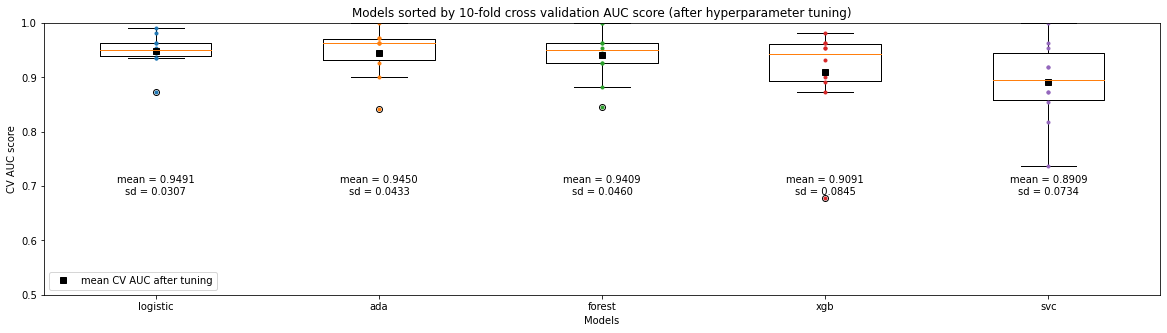

In [7]:
plt.boxplot(sorted_tuned_auc, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, auc in enumerate(sorted_tuned_auc):
  plt.plot([i+1]*len(auc), auc, ".")
  plt.annotate(f"mean = {np.mean(auc):0.4f}\nsd = {np.std(auc):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_auc)+1,1)], sorted(mean_tuned_auc, reverse=True), 
         "ks", label = 'mean CV AUC after tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0.5,1)
plt.ylabel("CV AUC score")
plt.show()

## Pick best model
- Based on 10-fold cross validation, logistic regression gave us the highest average ROC AUC score of 0.95
  - Applying ensemble methods (e.g. voting, stacking, bagging, boosting) on top of these tuned models didn't help boost CV performance
- Batch gradient descent vs Stochastic gradient descent
  - Instead of batch GD, stochastic GD speeds up training time, which can become useful as our dataset gets larger and larger with more NBA seasons recorded since 1996
  - Log loss is a convex function so there is no benefit of jumping out of "local minumum" in choosing stochastic GD 
  - Inherent randomness in being stochastic suggests there is room to tune learning rate and learning schedule

In [8]:
best_model = tuned_models['logistic'].best_estimator_

In [9]:
best_model

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('seasonsimilarity',
                                  SeasonSimilarity(n_clusters=2,
                                                   random_state=42)),
                                 ('selector',
                                  SelectFromModel(estimator=LogisticRegression(C=8.478490982264661,
                                                                               penalty='l1',
                                                                               random_state=42,
                                                                               solver='liblinear')))])),
                ('logistic',
                 LogisticRegression(C=0.005499426480345607,
                                    l1_ratio=0.015456616528867428,
                                    max_iter=1000, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

## Test set

In [10]:
test_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_test.pkl?raw=true")
# make a copy and split X and y
X_test = test_set.drop(columns = "PLAYOFF_RANKING").reset_index(drop = True).copy(deep = True)
y_test = test_set[["PLAYOFF_RANKING"]].values.reshape(-1,)

In [11]:
X_test.shape

(143, 52)

# Performance evaluation
- should I use cross_val_predict here for evaluation in test set?

## ROC curve and AUC score
- 10-fold cross validation on train set gives ROC AUC scores:
  - min = 0.7364
  - mean = 0.9491 (sd = 0.0734)
  - max = 1.0000
- ROC AUC score on test set = 0.8826
  - Around 1 SD below the mean ROC AUC on train set
  - Within expectation as its hyperparameters are tuned on cross validation of the train set
  - Interpretation
    - If we use the model to rank all the records in train set by the predicted probability of winning a championship and measure whether each pair is concordant or discordant, 
    - 88% of the pairs are concordant

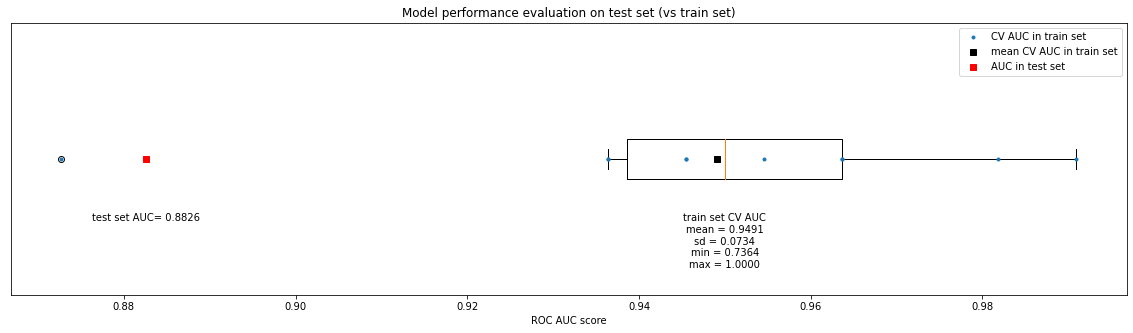

In [12]:
# plot CV AUC scores on train set
best_CV_AUC = sorted_tuned_auc[sorted_tuned_clf.index(best_model.steps[1][0])]
plt.boxplot(best_CV_AUC, labels = [""], vert=False)
plt.plot(best_CV_AUC, [1]*len(best_CV_AUC), ".", label='CV AUC in train set')
plt.annotate(f"train set CV AUC\n" + 
             f"mean = {np.mean(best_CV_AUC):0.4f}\n" + 
             f"sd = {np.std(auc):0.4f}\n" + 
             f"min = {np.min(auc):0.4f}\n" + 
             f"max = {np.max(auc):0.4f}",
             (np.median(best_CV_AUC), 0.8), 
              ha = 'center', va = 'top')
plt.plot(np.mean(best_CV_AUC), [1], "ks", label = 'mean CV AUC in train set')

# compare with AUC score on test set
test_AUC = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])
plt.plot(test_AUC, [1], "rs", label = 'AUC in test set')
plt.annotate(f"test set AUC= {test_AUC:0.4f}",(test_AUC, 0.8), 
              ha = 'center', va = 'top')

plt.legend()
plt.title(f"Model performance evaluation on test set (vs train set)")
plt.xlabel("ROC AUC score")
# plt.xlim(0.5,1)
plt.ylabel("")
plt.yticks([])
plt.show()

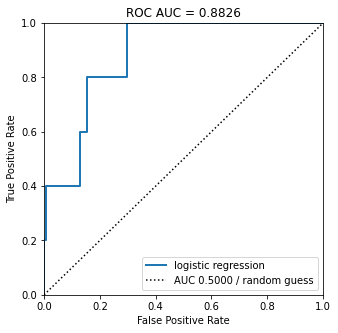

In [167]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linewidth = 2, label = f"logistic regression")
plt.plot([0,1], [0,1], 'k:', label = "AUC 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"ROC AUC = {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]):0.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()

## Lift and gain chart
- focusing on first 2 deciles (top 20%)
- gain chart: our model identifies 80% of the NBA champions
- lift chart: our model achieves 4x lift vs a random guess

In [75]:
temp_df = pd.DataFrame({
    'y': y_test,
    'prob': best_model.predict_proba(X_test)[:,1]
})
temp_df.sort_values('prob', ascending=False, inplace=True)
temp_df['decile'] = pd.qcut(temp_df['prob'],10,labels=[i for i in np.arange(10,0,-1)])

In [112]:
lift_n_gain = temp_df.groupby('decile').agg({'y': ['sum']}).sort_index(ascending=False)
lift_n_gain.columns = ['sum_of_positive_cases_identified']
lift_n_gain['gain'] = lift_n_gain[['sum_of_positive_cases_identified']].apply(lambda x: x.cumsum() / x.sum())
lift_n_gain['lift'] = lift_n_gain['gain'] / (lift_n_gain.index.values.astype(int) / 10)

In [152]:
lift_n_gain

,sum_of_positive_cases_identified,gain,lift
decile,,,
1,2,0.4,4.000000
2,2,0.8,4.000000
3,0,0.8,2.666667
4,1,1.0,2.500000
5,0,1.0,2.000000
6,0,1.0,1.666667
7,0,1.0,1.428571
8,0,1.0,1.250000
9,0,1.0,1.111111


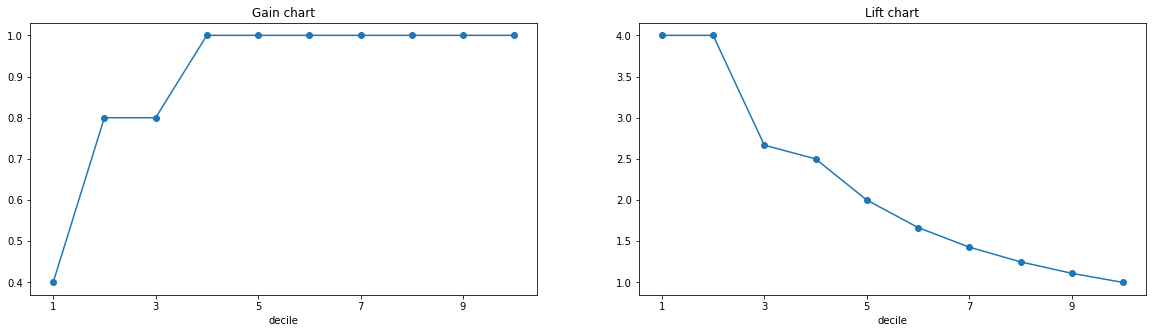

In [166]:
fig, axes = plt.subplots(1,2)
lift_n_gain['gain'].plot(kind='line', ax=axes[0], marker='o')
lift_n_gain['lift'].plot(kind='line', ax=axes[1], marker='o')
axes[0].set_title('Gain chart')
axes[1].set_title('Lift chart')
plt.show()

## Coefficients
- Before any manipulation, the data set contains 52 features
- After feature selection and other data cleaning procedures, there are 34 features remaining
- Finally, after fitting logistic regression with regularization, we can see that
  - significant variables: 
    - PLUS_MINUS (the average number of points a team has scored in excess of the number of points lost to the opponent in a game within the regular season)
    - W / L / W_PCT (the number (or %) of games a team has won/lost in the regular season)
      - surprisingly, applying elasticnet (L1 + L2 regularization) didn't help to eliminate the significance of these correlated variables
    - FG_PCT / FGM (field goal % and made)
  - interesting variables:
    - BLKA (blocks attempted) has a negative coefficient in predicting probability of winning a championship
      - perhaps attempting to block your opponent too frequently doesn't mean you are playing good defence 
    - 
- Overall, we can say that if a team performs well in the regular season, it is reasonable to assume that it can win the championship

Number of original features: 
52
['TEAM_ID' 'TEAM_NAME' 'GP' 'W' 'L' 'W_PCT' 'MIN' 'FGM' 'FGA' 'FG_PCT'
 'FG3M' 'FG3A' 'FG3_PCT' 'FTM' 'FTA' 'FT_PCT' 'OREB' 'DREB' 'REB' 'AST'
 'TOV' 'STL' 'BLK' 'BLKA' 'PF' 'PFD' 'PTS' 'PLUS_MINUS' 'CFID' 'CFPARAMS'
 'OPP_FGM' 'OPP_FGA' 'OPP_FG_PCT' 'OPP_FG3M' 'OPP_FG3A' 'OPP_FG3_PCT'
 'OPP_FTM' 'OPP_FTA' 'OPP_FT_PCT' 'OPP_OREB' 'OPP_DREB' 'OPP_REB'
 'OPP_AST' 'OPP_TOV' 'OPP_STL' 'OPP_BLK' 'OPP_BLKA' 'OPP_PF' 'OPP_PFD'
 'OPP_PTS' 'SEASON' 'UNIQUE_ID'] 

Number of features after feature engineering, scaling and selection: 
41
['W' 'L' 'W_PCT' 'FGM' 'FGA' 'FG_PCT' 'FG3M' 'FG3_PCT' 'FT_PCT' 'OREB'
 'DREB' 'REB' 'AST' 'TOV' 'BLK' 'BLKA' 'PF' 'PFD' 'PTS' 'PLUS_MINUS'
 'OPP_FGA' 'OPP_FG_PCT' 'OPP_FG3M' 'OPP_FG3A' 'OPP_FG3_PCT' 'OPP_FTM'
 'OPP_FTA' 'OPP_FT_PCT' 'OPP_OREB' 'OPP_DREB' 'OPP_REB' 'OPP_AST'
 'OPP_TOV' 'OPP_STL' 'OPP_BLK' 'OPP_PTS' 'FG2A' 'FG2M' 'FG2_FG3' 'ERA_0'
 'ERA_1'] 

Number of features after fitting estimator with regularization: 
28
featur

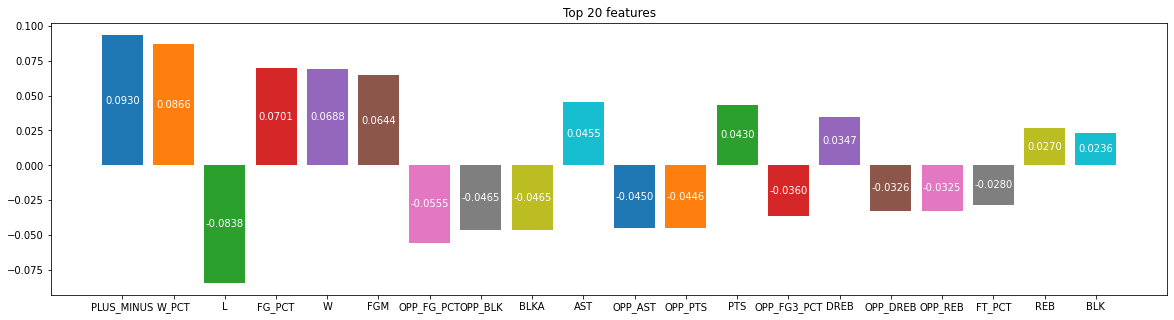

In [14]:
# original features
features_in = X_test.columns.values # cannot use features_in here since data_cleaning pipeline is wrapped in SeasonSimilarity instead of part of data_preparation pipeline
print(f"Number of original features: \n{len(X_test.columns.values)}")
print(features_in, "\n")

# sparse features after feature selection with L1 penalty in data_preparation pipeline
features_out = best_model[:-1].get_feature_names_out() 
print(f"Number of features after feature engineering, scaling and selection: \n{len(features_out)}")
print(features_out, "\n")

# non-zero (signficant) features after regularization in fitting estimator
coef = best_model.steps[1][1].coef_[0]
print(f"Number of features after fitting estimator with regularization: \n{np.count_nonzero(coef)}")
print(f"features = {[features_out[loc] for loc in np.nonzero(coef)[0]]}")
print(f"coefficient = {[np.around(coef[loc], decimals=4) for loc in np.nonzero(coef)[0]]}")

abs_coef = np.abs(coef)
fig, ax = plt.subplots(1,1)
for i, (_, coef, name) in enumerate(sorted(zip(abs_coef, coef, features_out), reverse=True)[:20]):
  ax.bar(name, coef)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.title("Top 20 features")
plt.show()

## Precision and recall curve
- As a team manager or as a fan, precision of the prediction matters more than recall
- Issues even with an AUC of 0.88 on test set
  - Setting cutoff threshold is difficult given the class imbalance in our data
  - Given a small test set, you can set a threshold just below the highest predicted probability to reach 100% precision
  - But going forward, can this threshold result in a consistently high precision?
  - Histogram of predicted probabilities shows a long right tail with the peak at around 2.5%
  - Most of the time you won't be more than 25% sure that your team can win the championship given your team's mid-season performance
  - Would this change if I have a larger test set to try on? or is the inherent class imbalance in the data that makes it hard to have a high precision?

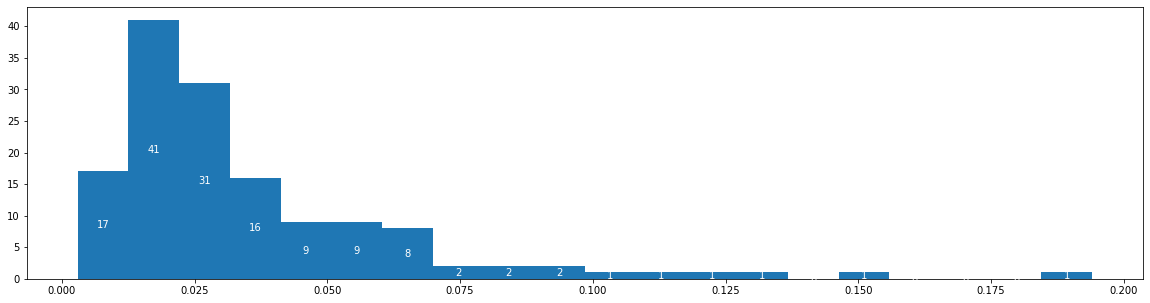

In [47]:
fig, ax = plt.subplots(1,1)
ax.hist(best_model.predict_proba(X_test)[:,1], bins = 20)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.0f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.show()

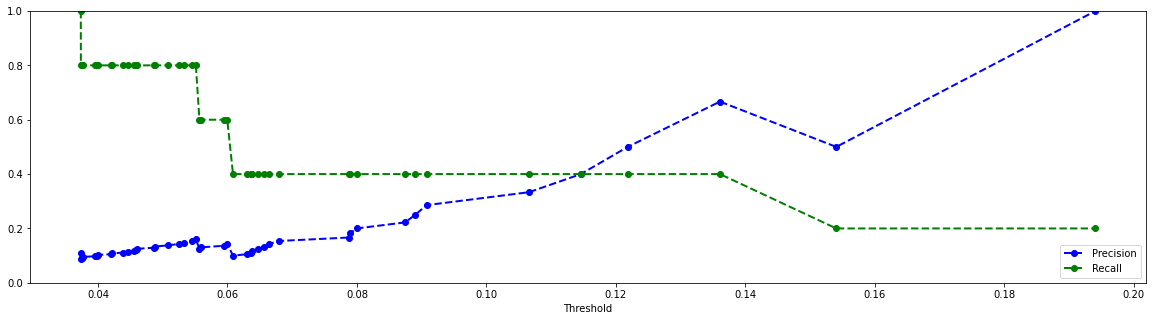

In [46]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
precisions, recalls, thresholds = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:,1])
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
# plt.axhline(0.9, c='k')
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.legend()
plt.show()

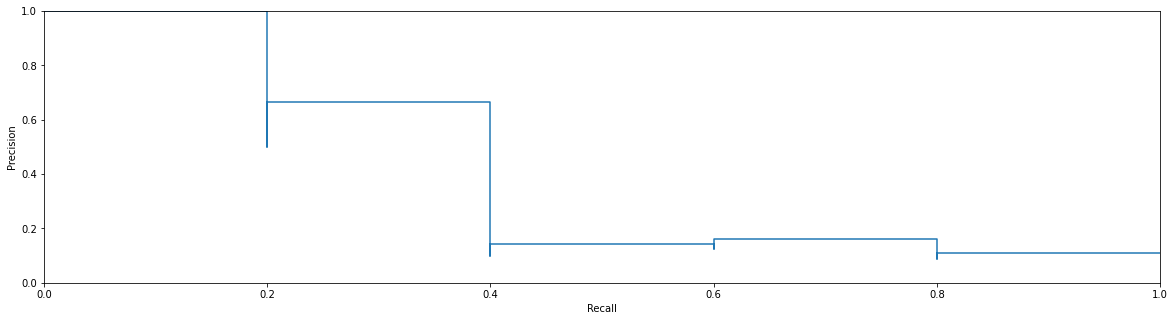

In [17]:
PrecisionRecallDisplay(precision=precisions, recall=recalls).plot()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

## Confusion matrix

In [37]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

In [33]:
# to achieve a precision of 80% or more
precision_pct = 0.8

In [40]:
# due to class imbalance in a small test set, 
# the threshold intervals are so sparse that it becomes hard to achieve exactly 80%
idx_for_chosen_precision = (precisions >= precision_pct).argmax()
chosen_threshold = thresholds[idx_for_chosen_precision]
y_predict = (best_model.predict_proba(X_test)[:,1] >= chosen_threshold)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       138
           1       1.00      0.20      0.33         5

    accuracy                           0.97       143
   macro avg       0.99      0.60      0.66       143
weighted avg       0.97      0.97      0.96       143



In [35]:
# only 1 instance was predicted and correctly identified as positive (winning a championship)
confusion_matrix(y_test, y_predict)

array([[138,   0],
       [  4,   1]])